# TattiSketch - LoRA адаптер для стиля "одной линии"


# Инструкция для запуска ноутбука

Этот ноутбук выполняет:
- обучение LoRA-адаптера на датасете из 50-ти эскизов тату (выполнены в стиле одной непрерывной линии) с использованием платформы Fal.ai;
- генерацию изображений на baseline-модели (fal-ai/flux/dev);
- генерацию изображений на обученном LoRA-адаптере;
- расчет, оценку и визуализацию метрик

**Для корректной работы требуется:**
- установить свой API-ключ Fal.ai через `userdata` или переменную `FAL_KEY`;
- загрузить архив `dataset.zip` с датасетом изображений в папку `/content/` в Google Colab;
- загрузить `sample_line.png` в папку `/content/dataset/` для оценки метрик.

---


## 1. Установка зависимостей

In [1]:
!pip install fal-client requests Pillow opencv-python matplotlib pytorch-fid scikit-image torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 2. Настройка API и импорт библиотек


In [2]:
import fal_client
import requests
import os
import time
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.models as models
from torchvision import transforms
from google.colab import userdata
from fal_client import Queued, InProgress, Completed

## Конфигурация


In [3]:
FAL_KEY = userdata.get('FAL_API_KEY')
os.environ["FAL_KEY"] = FAL_KEY

REFERENCE_IMAGE_PATH = "/content/dataset/sample_line.png"

## 3. Загрузка датасета

In [4]:
!mkdir -p dataset generated

- загрузить /content/dataset.zip - для обучения в Fal.ai
- загрузить /content/dataset/sample_line.png - для оценки метрик в дальнейшем

In [ ]:
data_zip_url = fal_client.upload_file("dataset.zip")
print("ZIP загружен:", data_zip_url)

ZIP загружен: https://v3.fal.media/files/zebra/dnP9RLGHxdzD3hPqwghNQ_dataset.zip


## 4. Обучение LoRA-адаптера на платформе Fal.ai


In [ ]:
handler = fal_client.submit(
    "fal-ai/flux-lora-fast-training",
    arguments={
        "images_data_url": data_zip_url,
        "is_style": True,
        "steps": 1000,
        "trigger_word": "single_line_style",
        "create_masks": False
    }
)

while True:
    status = fal_client.status(
        "fal-ai/flux-lora-fast-training",
        handler.request_id,
        with_logs=True
    )

    if isinstance(status, Queued):
        print(f"В очереди (position={status.position})")

    elif isinstance(status, InProgress):
        for log in status.logs or []:
            print(log.get("message", "<no message>"))

    elif isinstance(status, Completed):
        print("Обучение завершено!")
        break

    else:
        raise RuntimeError(f"Unexpected status object: {status!r}")

    time.sleep(30)

result = fal_client.result("fal-ai/flux-lora-fast-training", handler.request_id)
lora_url = result["diffusers_lora_file"]["url"]
print("LoRA weights:", lora_url)

В очереди (position=0)
Image /tmp/tmp0qqb_pte/39.png has width 512 and height 512
Saving at /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/39.jpg
Moving /tmp/tmp0qqb_pte/12.png to /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/12.png
Image /tmp/tmp0qqb_pte/12.png has width 512 and height 512
Saving at /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/12.jpg
Moving /tmp/tmp0qqb_pte/16.png to /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/16.png
Image /tmp/tmp0qqb_pte/16.png has width 512 and height 512
Saving at /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/16.jpg
Moving /tmp/tmp0qqb_pte/7.png to /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/7.png
Image /tmp/tmp0qqb_pte/7.png has width 512 and height 512
Saving at /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/7.jpg
Moving /tmp/tmp0qqb_pte/40.png to /tmp/tmppfrbz3dy/flux_general/b0d4fe2900ac4eb7/train/40.png
Image /tmp/tmp0qqb_pte/40.png has width 512 and height 512
Saving at /tmp/tmppfrbz3dy/flu

Файл весов обученного LoRA-адаптера:

In [9]:
lora_url = "https://v3.fal.media/files/rabbit/IpeqdD0VNgvEes5hChm97_pytorch_lora_weights.safetensors"

## 5. Генерация изображений:
- baseline - fal-ai/flux/dev;
- lora - fal-ai/flux/dev + LoRA (триггер - single_line_style)

In [10]:
MODEL_SLUG = "fal-ai/flux/dev"

prompts = ["flower", "dragon", "wolf head"]

def generate_image(prompt, use_lora=False):
    arguments = {
        "prompt": prompt,
        "image_size": {"width": 512, "height": 512}
    }

    if use_lora:

        arguments["prompt"] = f"{prompt} <single_line_style>"
        arguments["lora_urls"] = [lora_url]

    response = fal_client.run(MODEL_SLUG, arguments=arguments)
    img_data = requests.get(response["images"][0]["url"], stream=True)
    return Image.open(img_data.raw).convert("RGB")

for i, prompt in enumerate(prompts):
    # Генерация без LoRA (Baseline)
    img_baseline = generate_image(prompt, use_lora=False)
    img_baseline.save(f"generated/baseline_{i}.png")

    # Генерация с LoRA (Стиль одной линии)
    img_lora = generate_image(prompt, use_lora=True)
    img_lora.save(f"generated/lora_{i}.png")


## 6. Метрики качества:

In [11]:
reference_img = Image.open(REFERENCE_IMAGE_PATH)

vgg = models.vgg19(pretrained=True).features.eval()

def gram_matrix(input):
    batch_size, depth, h, w = input.size()
    features = input.view(batch_size * depth, h * w)
    return torch.mm(features, features.t()) / (batch_size * depth * h * w)

def style_loss(generated, reference):

    generated = generated.convert("RGB")
    reference = reference.convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])
    gen_tensor = preprocess(generated).unsqueeze(0)
    ref_tensor = preprocess(reference).unsqueeze(0)
    gen_features = vgg(gen_tensor)
    ref_features = vgg(ref_tensor)
    return torch.mean((gram_matrix(gen_features) - gram_matrix(ref_features))**2)

metrics = {"Baseline": {"EC": [], "LCI": [], "StyleLoss": [], "HSS": []},
           "LoRA": {"EC": [], "LCI": [], "StyleLoss": [], "HSS": []}}

for i in range(len(prompts)):
    baseline_img = Image.open(f"generated/baseline_{i}.png")
    lora_img = Image.open(f"generated/lora_{i}.png")

    metrics["Baseline"]["EC"].append(len(cv2.findContours(
        cv2.Canny(cv2.cvtColor(np.array(baseline_img), cv2.COLOR_RGB2GRAY), 50, 150),
        cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )[0]))

    metrics["LoRA"]["EC"].append(len(cv2.findContours(
        cv2.Canny(cv2.cvtColor(np.array(lora_img), cv2.COLOR_RGB2GRAY), 50, 150),
        cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )[0]))

    metrics["Baseline"]["LCI"].append(len(cv2.goodFeaturesToTrack(
        cv2.cvtColor(np.array(baseline_img), cv2.COLOR_RGB2GRAY),
        maxCorners=100, qualityLevel=0.01, minDistance=10
    )))

    metrics["LoRA"]["LCI"].append(len(cv2.goodFeaturesToTrack(
        cv2.cvtColor(np.array(lora_img), cv2.COLOR_RGB2GRAY),
        maxCorners=100, qualityLevel=0.01, minDistance=10
    )))

    metrics["Baseline"]["StyleLoss"].append(style_loss(baseline_img, reference_img).item())
    metrics["LoRA"]["StyleLoss"].append(style_loss(lora_img, reference_img).item())

print("Введите Human Style Scores от 1 до 5 для каждого изображения:")
for model in ["Baseline", "LoRA"]:
    for i, prompt in enumerate(prompts):
        score = float(input(f"{model} - {prompt}: "))
        metrics[model]["HSS"].append(score)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.5MB/s]


Введите Human Style Scores от 1 до 5 для каждого изображения:
Baseline - flower: 1
Baseline - dragon: 1
Baseline - wolf head: 1
LoRA - flower: 2
LoRA - dragon: 2
LoRA - wolf head: 2


## Значения метрик:

In [12]:
def print_metrics(metrics_dict):
    for model_name, model_metrics in metrics_dict.items():
        print(f"\n=== {model_name} ===")
        for metric_name, values in model_metrics.items():
            mean_val = np.mean(values)
            std_val  = np.std(values)
            print(f"{metric_name:12s}: mean = {mean_val:.4e}, std = {std_val:.4e}")

print_metrics(metrics)


=== Baseline ===
EC          : mean = 9.8367e+02, std = 5.6468e+02
LCI         : mean = 1.0000e+02, std = 0.0000e+00
StyleLoss   : mean = 8.0838e-07, std = 3.3115e-07
HSS         : mean = 1.0000e+00, std = 0.0000e+00

=== LoRA ===
EC          : mean = 1.1907e+03, std = 3.5021e+02
LCI         : mean = 1.0000e+02, std = 0.0000e+00
StyleLoss   : mean = 1.7868e-07, std = 6.2718e-08
HSS         : mean = 2.0000e+00, std = 0.0000e+00


## 7. Визуализация результатов:

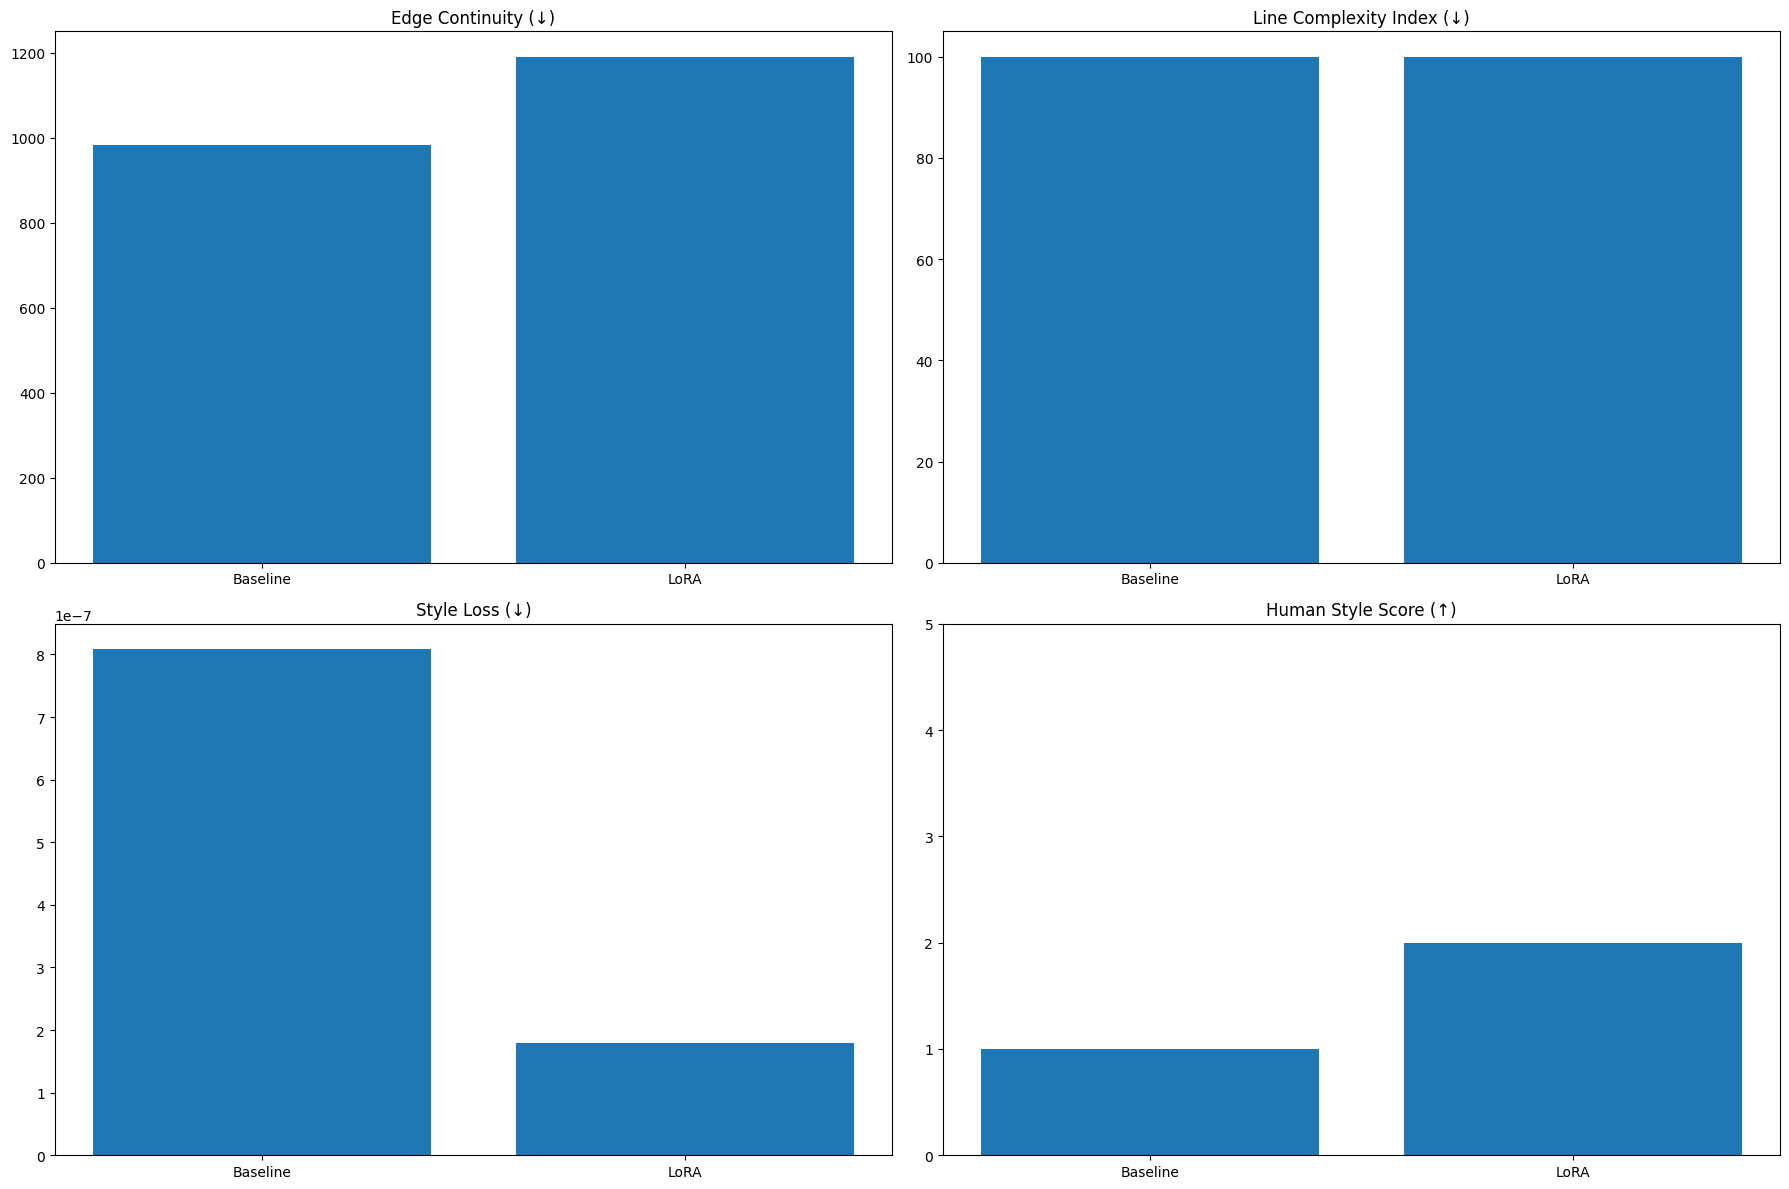

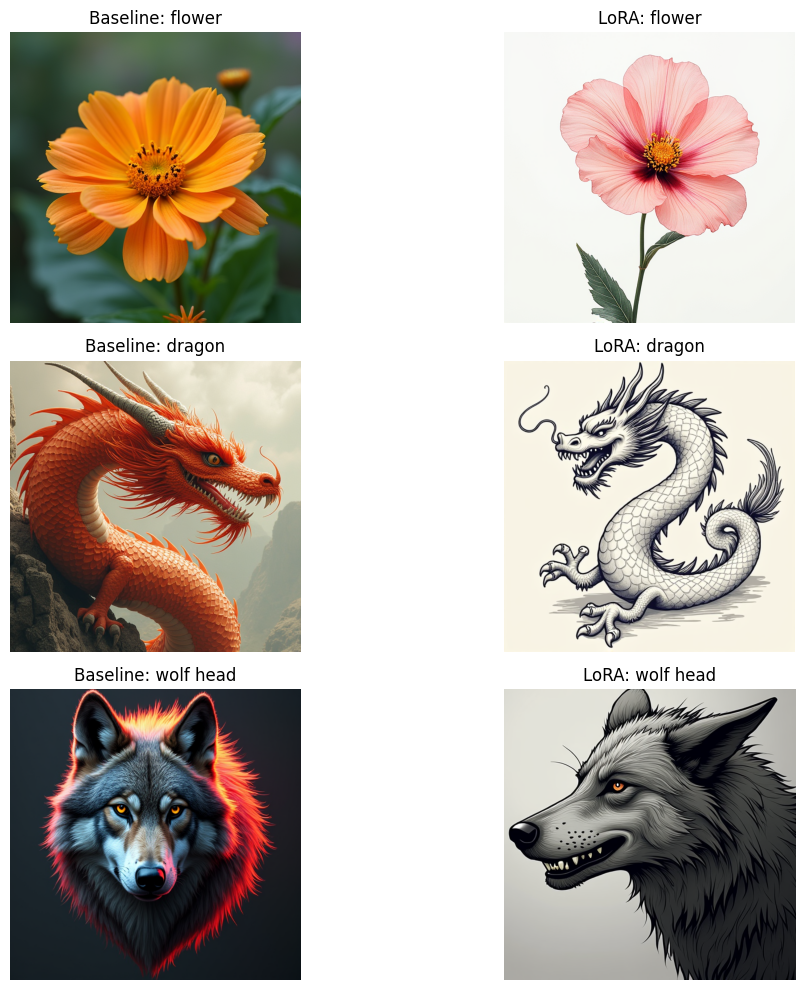

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["EC"]), np.mean(metrics["LoRA"]["EC"])])
axs[0, 0].set_title("Edge Continuity (↓)")

axs[0, 1].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["LCI"]), np.mean(metrics["LoRA"]["LCI"])])
axs[0, 1].set_title("Line Complexity Index (↓)")

axs[1, 0].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["StyleLoss"]), np.mean(metrics["LoRA"]["StyleLoss"])])
axs[1, 0].set_title("Style Loss (↓)")

axs[1, 1].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["HSS"]), np.mean(metrics["LoRA"]["HSS"])])
axs[1, 1].set_title("Human Style Score (↑)")
axs[1, 1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(len(prompts), 2, figsize=(12, 10))
for i in range(len(prompts)):
    ax[i,0].imshow(Image.open(f"generated/baseline_{i}.png"))
    ax[i,0].set_title(f"Baseline: {prompts[i]}")
    ax[i,0].axis("off")

    ax[i,1].imshow(Image.open(f"generated/lora_{i}.png"))
    ax[i,1].set_title(f"LoRA: {prompts[i]}")
    ax[i,1].axis("off")

plt.tight_layout()
plt.show()


## Вывод: результаты стали значительно ближе к стилистике скетча (особенно дракон) — но реализации техники "одной линией" пока нет.

**Причина:**
- Fal-ai/flux — это базовый text-to-image движок - он не был специально натренирован на следование правилам "одной линии", и полученные веса LoRA не позволяют достичь требуемого результата.

**Предложения по улучшению результата:**
- Улучшить датасет: взять не 50, а 100-200 референсов, где именно одна линия без разрывов (без шумов, без фона, без теней, все изображения одинакового размера и черно-белые).

- Тренировать больше шагов: 3000–5000 шагов дадут лучшее закрепление.

- Задать триггер-слово в prompt-е: вместо `single_line_style` можно использовать промпт типа: `single continuous black line drawing, minimalism, no shading, no breaks`.